In [1]:
import xarray as xr
import numpy as np
from pyDOE import lhs
import sklearn.preprocessing as skp
import sklearn.svm as sksv
import sklearn.ensemble as ske

import pylab as pl
pl.style.use("publication")

from matplotlib.colors import LogNorm, SymLogNorm


class MidpointNormalize(pl.matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        pl.matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

%matplotlib inline

We will try to map a complex (strongly non-linear) function with as few a samples as possible.

We will use the McCormick function .

In order to map that function, we will combine two tools : an efficient latin hypercube sampler and a support vector regression with a gaussian kernel trick.

In [2]:
def non_linear_function(*x):
    return sum([x_i**4 - 16 * x_i**2 + 5 * x_i / 2
                for x_i in x])

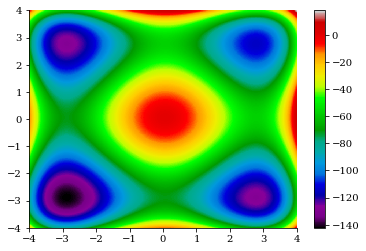

In [13]:
x = np.linspace(-4, 4, 1000)
y = np.linspace(-4, 4, 1000)
z = non_linear_function(*np.meshgrid(x, y))

pl.pcolormesh(x, y, z, cmap="nipy_spectral")
pl.colorbar()

In [8]:
def map_function(n_sample, non_linear_function):
    x = np.linspace(-4, 4, 1000)
    y = np.linspace(-4, 4, 1000)
    z = non_linear_function(*np.meshgrid(x, y))

    minmax_scale = skp.MinMaxScaler(feature_range=(-4, 4))
    std_scale = skp.StandardScaler()
    X = minmax_scale.fit_transform(lhs(2, samples=n_sample))
    Y = std_scale.fit_transform(non_linear_function(*X.T)[:, None]).squeeze()

    fig, axs = pl.subplots(1, 3, sharex="all", sharey="all", figsize=(12, 3))
    pl.sca(axs[0])
    pl.contour(x, y, z, 5, cmap="nipy_spectral",
                  vmin=-130, vmax=0)
    pl.scatter(*X.T, c=std_scale.inverse_transform(Y),
               cmap="nipy_spectral", edgecolors="black",
               vmin=-130, vmax=0)
    pl.colorbar()
    pl.xlim(-4, 4)
    pl.ylim(-4, 4)

    regressor = sksv.SVR()
    regressor.fit(X, Y)
    xx, yy = np.meshgrid(x, y)
    YY = regressor.predict(np.vstack([xx.flatten(),
                                      yy.flatten()]).T).reshape(xx.shape)

    pl.sca(axs[1])
    pl.pcolormesh(xx, yy, std_scale.inverse_transform(YY),
                  cmap="nipy_spectral",
                  vmin=-130, vmax=0)
    pl.colorbar()
    pl.sca(axs[2])
    pl.pcolormesh(xx, yy, (np.abs(std_scale.inverse_transform(YY) -
                                  non_linear_function(xx, yy)) /
                           (np.abs(non_linear_function(xx, yy)) + 1)),
                  cmap="RdGy_r", norm=MidpointNormalize(1E-3, 1, .3))
    pl.colorbar()

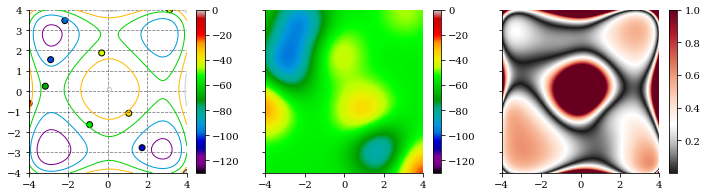

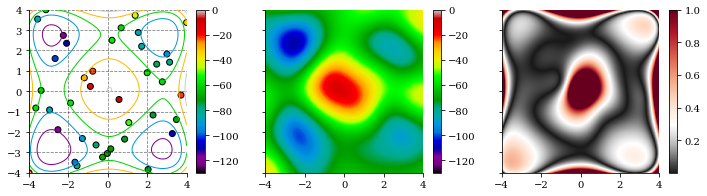

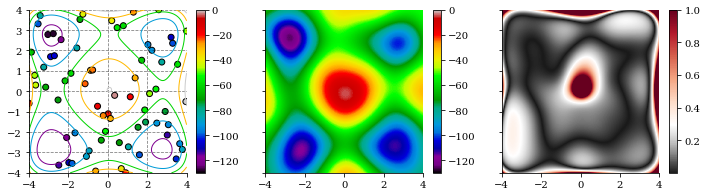

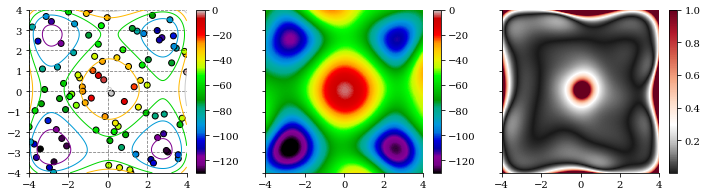

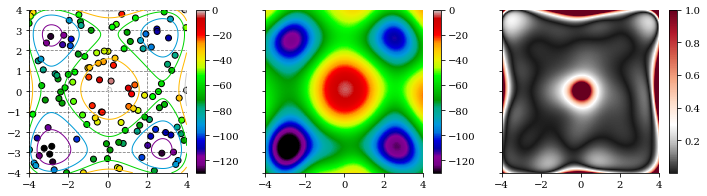

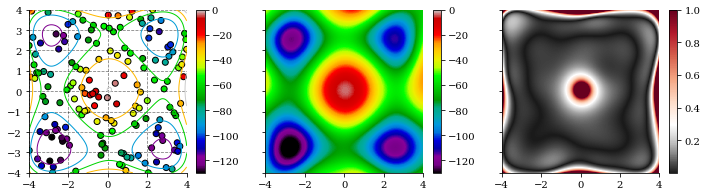

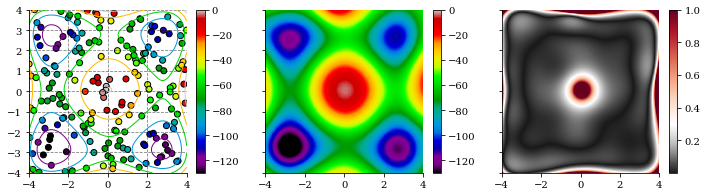

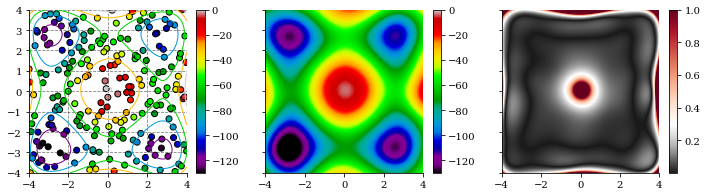

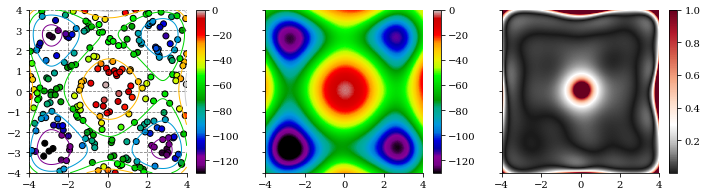

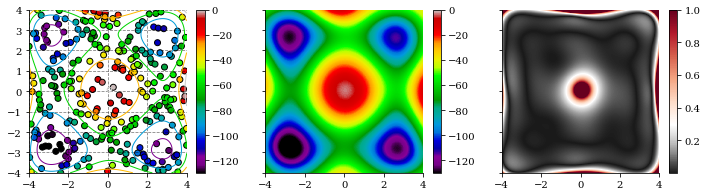

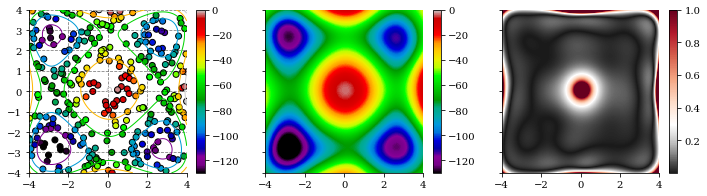

In [11]:
for n_sample in range(10, 320, 30):
    map_function(n_sample, non_linear_function)